In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
from statsmodels.tsa.arima.model import ARIMA
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
import itertools

In [7]:
# Load the data
data = pd.read_csv("..\\data\\raw\\bitcoin.csv")

# Convert the timestamp to a datetime object
data['Timestamp'] = pd.to_datetime(data['Timestamp'], unit='s')

# Sort the data in chronological order
data = data.sort_values(by='Timestamp')

# Handle missing values
data = data.ffill()  # Forward-fill to fill missing values

# Display the first few rows
print(data.head())

# Summary statistics
print(data.describe())

# Check for missing values
print(data.isnull().sum())


            Timestamp  Open  High   Low  Close  Volume_(BTC)  \
0 2011-12-31 07:52:00  4.39  4.39  4.39   4.39      0.455581   
1 2011-12-31 07:53:00  4.39  4.39  4.39   4.39      0.455581   
2 2011-12-31 07:54:00  4.39  4.39  4.39   4.39      0.455581   
3 2011-12-31 07:55:00  4.39  4.39  4.39   4.39      0.455581   
4 2011-12-31 07:56:00  4.39  4.39  4.39   4.39      0.455581   

   Volume_(Currency)  Weighted_Price  
0                2.0            4.39  
1                2.0            4.39  
2                2.0            4.39  
3                2.0            4.39  
4                2.0            4.39  
               Open          High           Low         Close  Volume_(BTC)  \
count  4.857377e+06  4.857377e+06  4.857377e+06  4.857377e+06  4.857377e+06   
mean   4.591960e+03  4.595217e+03  4.588553e+03  4.591953e+03  9.474175e+00   
std    8.157754e+03  8.164281e+03  8.151040e+03  8.157843e+03  3.064199e+01   
min    3.800000e+00  3.800000e+00  1.500000e+00  1.500000e+00  0.

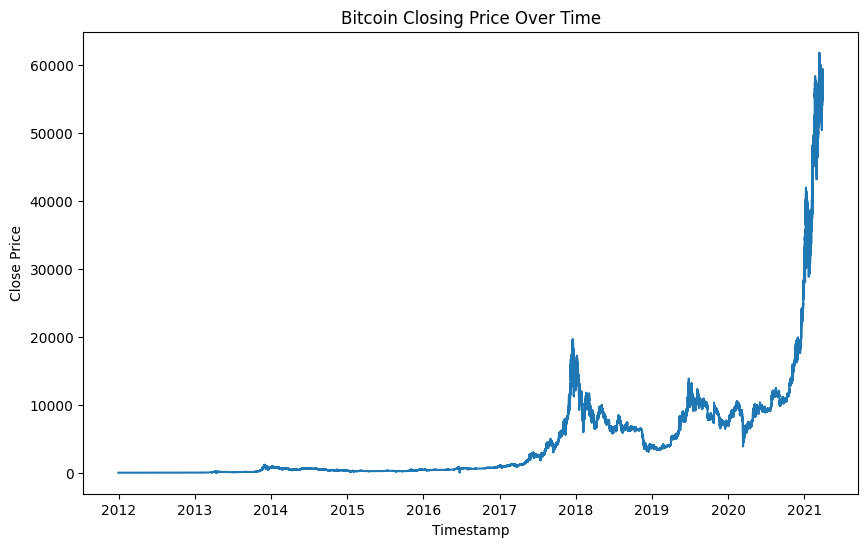

In [8]:
# Plot the closing price over time
plt.figure(figsize=(10, 6))
plt.plot(data['Timestamp'], data['Close'])
plt.xlabel('Timestamp')
plt.ylabel('Close Price')
plt.title('Bitcoin Closing Price Over Time')
plt.show()

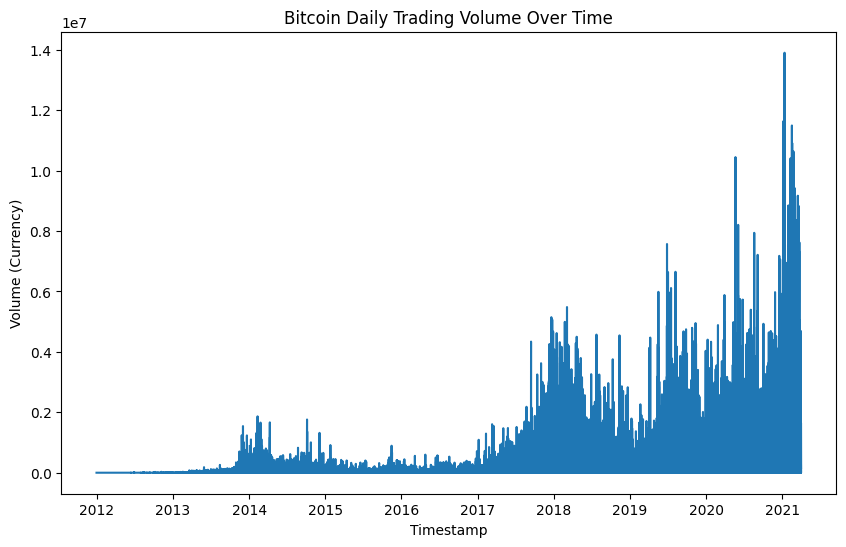

In [9]:
# Plot the daily trading volume over time
plt.figure(figsize=(10, 6))
plt.plot(data['Timestamp'], data['Volume_(Currency)'])
plt.xlabel('Timestamp')
plt.ylabel('Volume (Currency)')
plt.title('Bitcoin Daily Trading Volume Over Time')
plt.show()


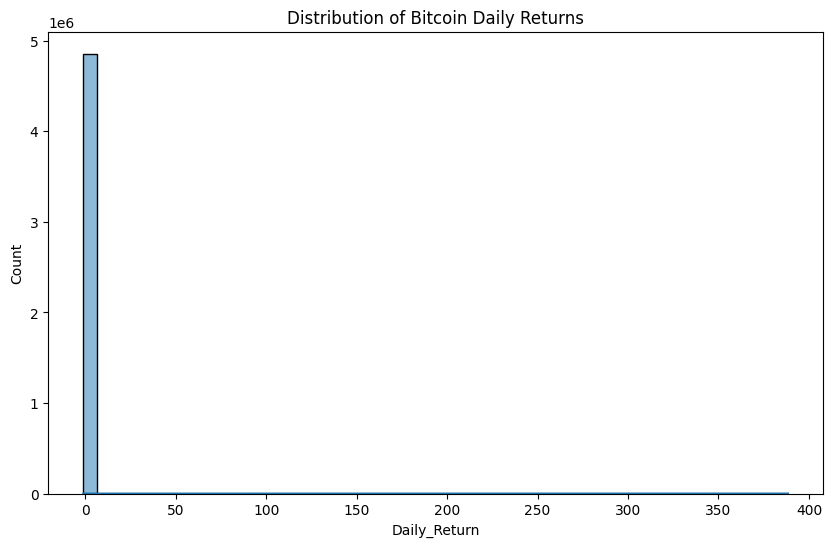

In [10]:

# Calculate daily returns
data['Daily_Return'] = data['Close'].pct_change()

# Plot the distribution of daily returns
plt.figure(figsize=(10, 6))
sns.histplot(data=data, x='Daily_Return', bins=50, kde=True)
plt.title('Distribution of Bitcoin Daily Returns')
plt.show()

                       Open      High       Low     Close  Volume_(BTC)  \
Open               1.000000  0.999999  0.999999  0.999999     -0.048393   
High               0.999999  1.000000  0.999999  0.999999     -0.048274   
Low                0.999999  0.999999  1.000000  0.999999     -0.048542   
Close              0.999999  0.999999  0.999999  1.000000     -0.048407   
Volume_(BTC)      -0.048393 -0.048274 -0.048542 -0.048407      1.000000   
Volume_(Currency)  0.364410  0.364810  0.363907  0.364374      0.301502   
Weighted_Price     0.999999  1.000000  1.000000  1.000000     -0.048415   
Daily_Return      -0.000226 -0.000223 -0.000223 -0.000220     -0.000255   

                   Volume_(Currency)  Weighted_Price  Daily_Return  
Open                        0.364410        0.999999     -0.000226  
High                        0.364810        1.000000     -0.000223  
Low                         0.363907        1.000000     -0.000223  
Close                       0.364374        1.00

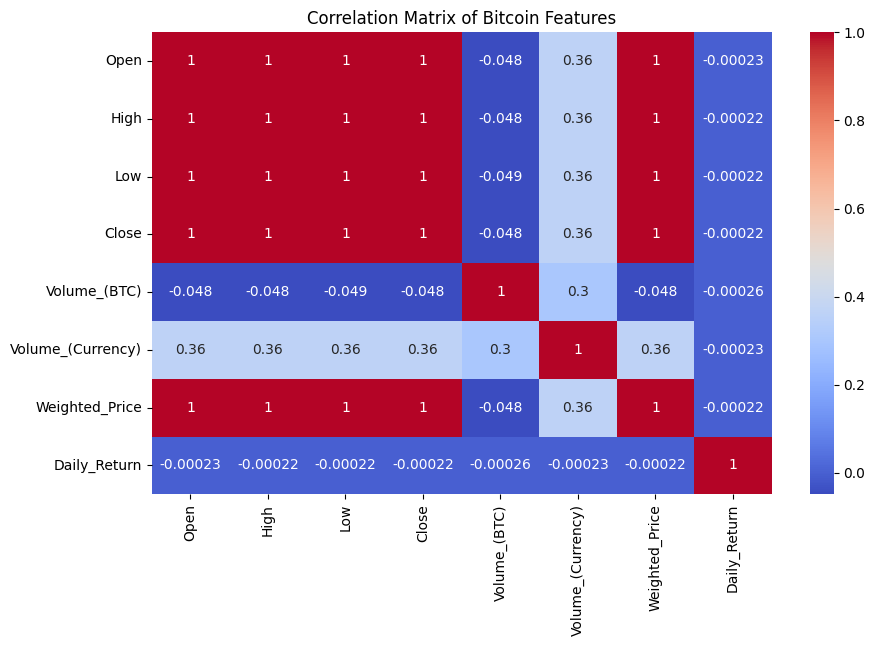

In [11]:
# Correlation matrix
corr_matrix = data[['Open', 'High', 'Low', 'Close', 'Volume_(BTC)', 'Volume_(Currency)', 'Weighted_Price', 'Daily_Return']].corr()
print(corr_matrix)

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Bitcoin Features')
plt.show()

In [29]:
# Load the dataset
data = pd.read_csv('..\\data\\raw\\bitcoin.csv')
data['Timestamp'] = pd.to_datetime(data['Timestamp'], unit='s')
data = data.set_index('Timestamp')
data = data.resample('D').mean()
data = data.dropna()

# Extract the 'Close' column and convert it to a NumPy array
closing_prices = data['Close'].values
closing_prices = closing_prices.reshape(-1, 1)

In [34]:
# Split the dataset into training and testing sets
train_size = int(len(closing_prices) * 0.8)
train_set, test_set = closing_prices[:train_size], closing_prices[train_size:]

p = range(0, 4)
d = range(0, 2)
q = range(0, 4)

pdq_combinations = list(itertools.product(p, d, q))

best_mse = float("inf")
best_params = None

for pdq in pdq_combinations:
    try:
        arima_model = ARIMA(train_set, order=pdq, enforce_stationarity=True, enforce_invertibility=True)
        arima_model_fit = arima_model.fit()

        y_pred_arima = arima_model_fit.forecast(steps=len(test_set))
        mse_arima = mean_squared_error(test_set, y_pred_arima)

        if mse_arima < best_mse:
            best_mse = mse_arima
            best_params = pdq
    except:
        continue

print("Best parameters:", best_params)
print("Best Mean Squared Error:", best_mse)

# Fit the ARIMA model using the best parameters
arima_model = ARIMA(train_set, order=best_params)
arima_model_fit = arima_model.fit()

# Predict the closing prices for the test set
y_pred_arima = arima_model_fit.forecast(steps=len(test_set))

# Calculate and print the evaluation metrics
mse_arima = mean_squared_error(test_set, y_pred_arima)
mae_arima = mean_absolute_error(test_set, y_pred_arima)
print('ARIMA Mean Squared Error:', mse_arima)
print('ARIMA Mean Absolute Error:', mae_arima)



C:\Users\MasterLaptop\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\MasterLaptop\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\MasterLaptop\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\MasterLaptop\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters f

Best parameters: (3, 1, 3)
Best Mean Squared Error: 208401656.8515548


C:\Users\MasterLaptop\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\MasterLaptop\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA Mean Squared Error: 208401656.8515548
ARIMA Mean Absolute Error: 7175.8414700156145


In [18]:
# Create and train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict the closing prices for the testing set
y_pred = model.predict(X_test)

# Calculate and print the evaluation metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")

Mean Squared Error: 38122503.77
Mean Absolute Error: 3484.03


In [23]:
# Prepare the dataset
data = pd.read_csv("..\\data\\raw\\bitcoin.csv")
data["Timestamp"] = pd.to_datetime(data["Timestamp"], unit="s")
data.set_index("Timestamp", inplace=True)
data = data.interpolate(method="time")

# Split the dataset into training and testing sets
train_data, test_data = data[:-100], data[-100:]

# Fit the ARIMA model
model = ARIMA(train_data["Close"], order=(5, 1, 0))
model_fit = model.fit()

# Forecast the next 100 values
forecast = model_fit.forecast(steps=100)

# Calculate the evaluation metrics
mse = mean_squared_error(test_data["Close"], forecast)
mae = mean_absolute_error(test_data["Close"], forecast)

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)

C:\Users\MasterLaptop\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\MasterLaptop\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\MasterLaptop\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\MasterLaptop\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarnin

Mean Squared Error: 48510.97218191887
Mean Absolute Error: 207.47500309834643


In [35]:
# Scale the data to the range [0, 1]
scaler = MinMaxScaler(feature_range=(0, 1))
closing_prices_scaled = scaler.fit_transform(closing_prices)

# Split the dataset into training and testing sets
train_size = int(len(closing_prices_scaled) * 0.8)
train_set_lstm, test_set_lstm = closing_prices_scaled[:train_size], closing_prices_scaled[train_size:]

# Create a function to prepare the data for LSTM
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i : (i + look_back), 0])
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

# Prepare the data for LSTM
look_back = 1
X_train_lstm, y_train_lstm = create_dataset(train_set_lstm, look_back)
X_test_lstm, y_test_lstm = create_dataset(test_set_lstm, look_back)

# Reshape the data to the format required by LSTM
X_train_lstm = np.reshape(X_train_lstm, (X_train_lstm.shape[0], 1, X_train_lstm.shape[1]))
X_test_lstm = np.reshape(X_test_lstm, (X_test_lstm.shape[0], 1, X_test_lstm.shape[1]))

# Create and fit the LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(50, input_shape=(1, look_back)))
lstm_model.add(Dense(1))
lstm_model.compile(loss='mean_squared_error', optimizer='adam')
lstm_model.fit(X_train_lstm, y_train_lstm, epochs=10, batch_size=1, verbose=2)

# Predict the closing prices for the test set
y_pred_lstm = lstm_model.predict(X_test_lstm)

# Invert the scaling
y_pred_lstm_inv = scaler.inverse_transform(y_pred_lstm)
y_test_lstm_inv = scaler.inverse_transform(y_test_lstm.reshape(-1, 1))

# Calculate and print the evaluation metrics
mse_lstm = mean_squared_error(y_test_lstm_inv, y_pred_lstm_inv)
mae_lstm = mean_absolute_error(y_test_lstm_inv, y_pred_lstm_inv)
print('LSTM Mean Squared Error:', mse_lstm)
print('LSTM Mean Absolute Error:', mae_lstm)

Epoch 1/10
2699/2699 - 4s - loss: 2.5564e-04 - 4s/epoch - 1ms/step
Epoch 2/10
2699/2699 - 2s - loss: 1.4653e-05 - 2s/epoch - 904us/step
Epoch 3/10
2699/2699 - 2s - loss: 1.6257e-05 - 2s/epoch - 897us/step
Epoch 4/10
2699/2699 - 2s - loss: 1.3973e-05 - 2s/epoch - 893us/step
Epoch 5/10
2699/2699 - 2s - loss: 1.5519e-05 - 2s/epoch - 893us/step
Epoch 6/10
2699/2699 - 2s - loss: 1.4409e-05 - 2s/epoch - 891us/step
Epoch 7/10
2699/2699 - 2s - loss: 1.3809e-05 - 2s/epoch - 892us/step
Epoch 8/10
2699/2699 - 2s - loss: 1.5104e-05 - 2s/epoch - 900us/step
Epoch 9/10
2699/2699 - 2s - loss: 1.5213e-05 - 2s/epoch - 914us/step
Epoch 10/10
2699/2699 - 3s - loss: 1.4760e-05 - 3s/epoch - 927us/step
22/22 [==============================] - 0s 763us/step
LSTM Mean Squared Error: 2351082.7826706157
LSTM Mean Absolute Error: 700.6230934210294
